In [1]:
import pandas as pd

# Specify the file path for the dataset
file_path = 'chbmit_preprocessed_data.csv'

# Load the dataset into a DataFrame
data = pd.read_csv(file_path)

# Display the structure and basic information about the dataset
print("Dataset Information:")
print(data.info())  # Shows column names, non-null counts, and data types

# Display the first few rows of the dataset to understand its structure
print("\nSample Data:")
print(data.head())

# Display the number of rows and columns
num_rows, num_columns = data.shape
print(f"Number of rows: {num_rows}")
print(f"Number of columns: {num_columns}")

# Check the distribution of observations based on the 'outcome' column
class_distribution = data['Outcome'].value_counts()
print("\nClass Distribution:")
print(class_distribution)

# Display the percentage distribution for clarity
class_distribution_percent = data['Outcome'].value_counts(normalize=True) * 100
print("\nClass Distribution (Percentage):")
print(class_distribution_percent)

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2097150 entries, 0 to 2097149
Data columns (total 24 columns):
 #   Column    Dtype  
---  ------    -----  
 0   # FP1-F7  float64
 1   C3-P3     float64
 2   C4-P4     float64
 3   CZ-PZ     float64
 4   F3-C3     float64
 5   F4-C4     float64
 6   F7-T7     float64
 7   F8-T8     float64
 8   FP1-F3    float64
 9   FP2-F4    float64
 10  FP2-F8    float64
 11  FT10-T8   float64
 12  FT9-FT10  float64
 13  FZ-CZ     float64
 14  P3-O1     float64
 15  P4-O2     float64
 16  P7-O1     float64
 17  P7-T7     float64
 18  P8-O2     float64
 19  T7-FT9    float64
 20  T7-P7     float64
 21  T8-P8-0   float64
 22  T8-P8-1   float64
 23  Outcome   float64
dtypes: float64(24)
memory usage: 384.0 MB
None

Sample Data:
   # FP1-F7     C3-P3     C4-P4     CZ-PZ     F3-C3     F4-C4     F7-T7  \
0  0.000020  0.000010  0.000022  0.000037  0.000032  0.000035  0.000016   
1  0.000022  0.000008  0.000021  0.000039  0.000030  0.0

raw spectogram

Standardize of Data

In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Function to create sliding windows
def create_windows(data, window_size):
    windows = []
    for start in range(0, len(data) - window_size + 1, window_size):
        windows.append(data[start:start + window_size])
    return windows

# Standardizing the data
scaler = StandardScaler()

# Assuming `data` is your original DataFrame with 'Outcome' column
X = data.drop(columns=['Outcome'])  # Exclude the 'Outcome' column for standardization
X_standardized = scaler.fit_transform(X)

# Create a new DataFrame with standardized data
data_standardized = pd.DataFrame(X_standardized, columns=X.columns)
data_standardized['Outcome'] = data['Outcome']  # Add 'Outcome' column back

# Define the window size
window_size = 256  # Example window size

# Split the raw data based on the 'Outcome' column
outcome_0_data = data_standardized[data_standardized['Outcome'] == 0].drop(columns=['Outcome'])
outcome_1_data = data_standardized[data_standardized['Outcome'] == 1].drop(columns=['Outcome'])

# Create sliding windows for both outcome classes
outcome_0_windows = {col: create_windows(outcome_0_data[col].values, window_size) for col in outcome_0_data.columns}
outcome_1_windows = {col: create_windows(outcome_1_data[col].values, window_size) for col in outcome_1_data.columns}

# Save or return the standardized data and windows for further use
print("Standardization complete. Data is now ready for spectrogram generation.")


Standardization complete. Data is now ready for spectrogram generation.


Spectogram Generation

Testing spectrogram for Outcome 0, channel: # FP1-F7, sample index: 0
Spectrogram Frequency shape: (129,)
Spectrogram Time shape: (23,)
Spectrogram Data shape: (129, 23)
Spectrogram Data (min, max): 2.76759260698953e-18, 8.320163607920331e-11
Testing spectrogram for Outcome 1, channel: # FP1-F7, sample index: 0
Spectrogram Frequency shape: (129,)
Spectrogram Time shape: (23,)
Spectrogram Data shape: (129, 23)
Spectrogram Data (min, max): 1.483849316458979e-18, 6.931679247822872e-10


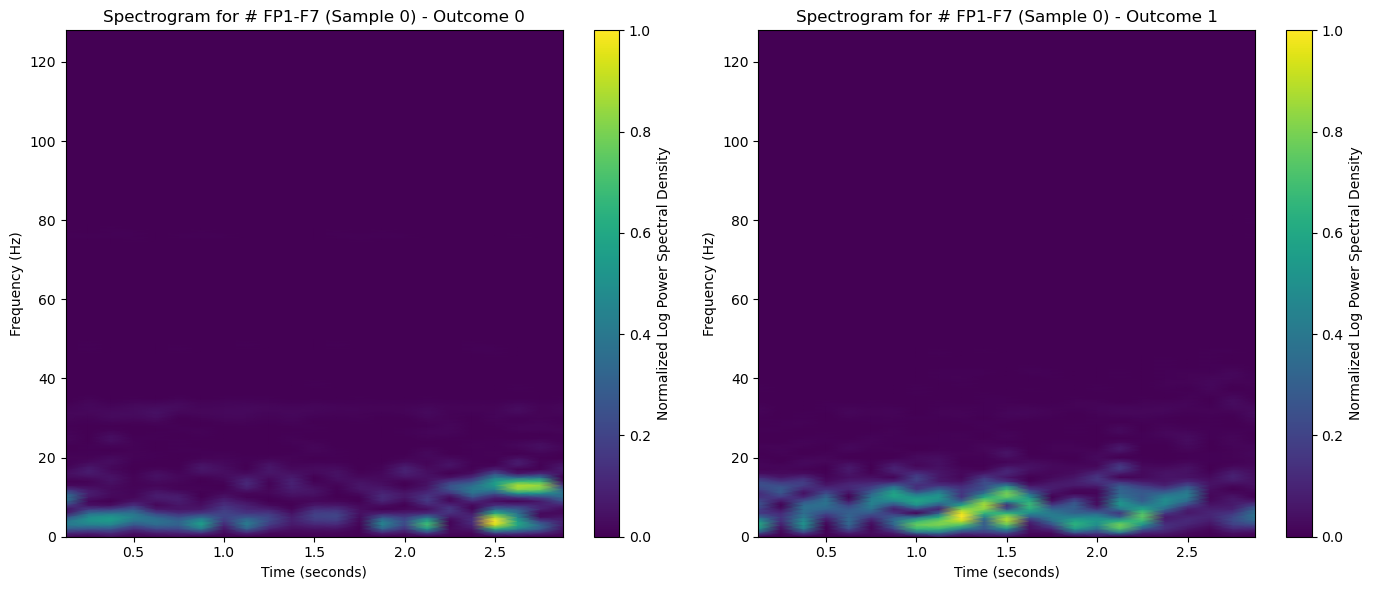

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import spectrogram

# Function to generate spectrogram
def generate_spectrogram(data_segment, fs=256, nperseg=64, noverlap=32, nfft=256):
    if len(data_segment) < nperseg:
        nperseg = len(data_segment)  # Adjust nperseg dynamically
    f, t, Sxx = spectrogram(data_segment, fs=fs, nperseg=nperseg, noverlap=noverlap, nfft=nfft)
    return f, t, Sxx

# Function to visualize the spectrogram
def visualize_spectrogram(f, t, Sxx, channel_name, sample_index, outcome):
    # Apply logarithmic scaling and normalization
    log_spectrogram = np.log10(Sxx + 1e-10) * 10  # Log scale with amplification
    log_spectrogram = (log_spectrogram - log_spectrogram.min()) / (log_spectrogram.max() - log_spectrogram.min())  # Normalize to [0, 1]

    # Plot the spectrogram
    plt.pcolormesh(t, f, log_spectrogram, cmap='viridis', shading='gouraud')
    plt.ylabel('Frequency (Hz)')
    plt.xlabel('Time (seconds)')
    plt.title(f'Spectrogram for {channel_name} (Sample {sample_index}) - Outcome {outcome}')
    plt.colorbar(label='Normalized Log Power Spectral Density')

# Test spectrogram generation with raw data
def test_spectrogram_on_raw_data(raw_data_segment, fs=256, nperseg=64, noverlap=32, nfft=256):
    f, t, Sxx = generate_spectrogram(raw_data_segment, fs, nperseg, noverlap, nfft)
    print(f"Spectrogram Frequency shape: {f.shape}")
    print(f"Spectrogram Time shape: {t.shape}")
    print(f"Spectrogram Data shape: {Sxx.shape}")
    print(f"Spectrogram Data (min, max): {Sxx.min()}, {Sxx.max()}")
    return f, t, Sxx

# Visualize spectrograms for both Outcome 0 and Outcome 1
def visualize_spectrogram_for_outcomes(outcome_data, channel_name, sample_index):
    plt.figure(figsize=(14, 6))  # Create a larger figure for side-by-side plots
    
    # Visualize Outcome 0
    print(f"Testing spectrogram for Outcome 0, channel: {channel_name}, sample index: {sample_index}")
    raw_data_segment_0 = outcome_data[0][channel_name][sample_index]  # Get raw data for Outcome 0
    f_0, t_0, Sxx_0 = test_spectrogram_on_raw_data(raw_data_segment_0)

    if Sxx_0.size > 0 and np.max(Sxx_0) > 1e-20:
        plt.subplot(1, 2, 1)  # First subplot (left)
        visualize_spectrogram(f_0, t_0, Sxx_0, channel_name, sample_index, outcome=0)
    else:
        print("Spectrogram data for Outcome 0 is empty or has very low power, skipping plot.")

    # Visualize Outcome 1
    print(f"Testing spectrogram for Outcome 1, channel: {channel_name}, sample index: {sample_index}")
    raw_data_segment_1 = outcome_data[1][channel_name][sample_index]  # Get raw data for Outcome 1
    f_1, t_1, Sxx_1 = test_spectrogram_on_raw_data(raw_data_segment_1)

    if Sxx_1.size > 0 and np.max(Sxx_1) > 1e-20:
        plt.subplot(1, 2, 2)  # Second subplot (right)
        visualize_spectrogram(f_1, t_1, Sxx_1, channel_name, sample_index, outcome=1)
    else:
        print("Spectrogram data for Outcome 1 is empty or has very low power, skipping plot.")

    plt.tight_layout()  # Adjust layout to avoid overlap
    plt.show()

# Assuming the standardized data and windows are ready from the previous steps
# Prepare the data windows for Outcome 0 and Outcome 1
outcome_0_data = data[data['Outcome'] == 0].drop(columns=['Outcome'])
outcome_1_data = data[data['Outcome'] == 1].drop(columns=['Outcome'])
window_size = 4000  # Define window size for analysis

outcome_0_windows = {col: create_windows(outcome_0_data[col].values, window_size) for col in outcome_0_data.columns}
outcome_1_windows = {col: create_windows(outcome_1_data[col].values, window_size) for col in outcome_1_data.columns}

# Choose the channel and sample index (same for both outcomes)
channel_name = '# FP1-F7'  # Example channel name
sample_index = 0  # Choose the first window/sample

# Visualize spectrograms for both Outcome 0 and Outcome 1
visualize_spectrogram_for_outcomes(
    outcome_data={0: outcome_0_windows, 1: outcome_1_windows}, 
    channel_name=channel_name, 
    sample_index=sample_index
)


Visualization of Spectogram

Directory 'spectrogram_images/' contains 16380 files.
Displaying up to 5 sample images:
Image: outcome_0_channel_# FP1-F7_sample_0.png


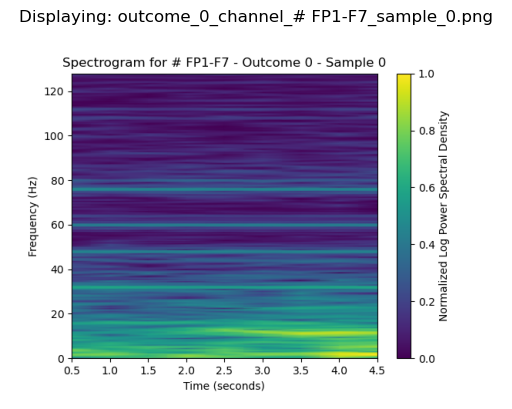

Image: outcome_0_channel_# FP1-F7_sample_1.png


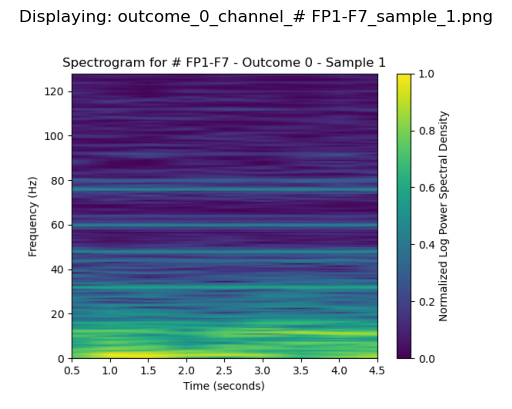

Image: outcome_0_channel_# FP1-F7_sample_10.png


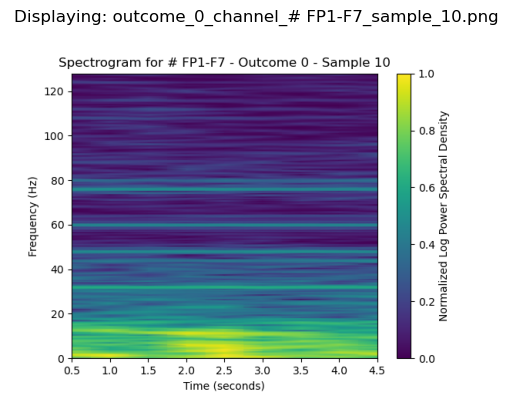

Image: outcome_0_channel_# FP1-F7_sample_100.png


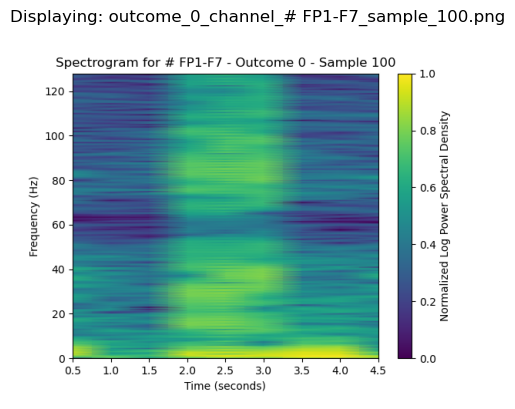

Image: outcome_0_channel_# FP1-F7_sample_101.png


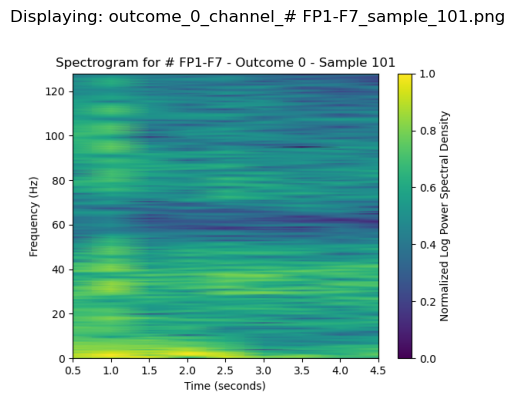

In [12]:
import os
from PIL import Image
import matplotlib.pyplot as plt

# Specify the directory you want to inspect
directory_path = "spectrogram_images/"  # Update this path if necessary

def list_files_in_directory(directory):
    """
    List all files in the given directory and return as a list.
    """
    if not os.path.exists(directory):
        print(f"Directory '{directory}' does not exist.")
        return []
    files = os.listdir(directory)
    if not files:
        print(f"Directory '{directory}' is empty.")
        return []
    print(f"Directory '{directory}' contains {len(files)} files.")
    return files

def display_image(file_path):
    """
    Load and display an image using PIL and matplotlib.
    """
    try:
        img = Image.open(file_path)
        plt.imshow(img)
        plt.axis("off")
        plt.title(f"Displaying: {os.path.basename(file_path)}")
        plt.show()
    except Exception as e:
        print(f"Error loading image {file_path}: {e}")

def main():
    # List files in the directory
    files = list_files_in_directory(directory_path)
    if not files:
        return
    
    # Display the first few images as examples
    print("Displaying up to 5 sample images:")
    for file_name in files[:5]:  # Adjust the number to display more/less
        file_path = os.path.join(directory_path, file_name)
        print(f"Image: {file_name}")
        display_image(file_path)

if __name__ == "__main__":
    main()


organizing, splitting and grayscaling of data set

In [55]:
import os
import shutil
import re
from sklearn.model_selection import train_test_split
from PIL import Image
import numpy as np

# Paths
source_dir = "spectrogram_images"  # Flat directory with all spectrogram images
output_dir = "processed_spectrogram_data"  # Organized dataset directory
categories = ['Outcome_0', 'Outcome_1']  # Class labels
split_ratios = {'train': 0.7, 'validation': 0.15, 'test': 0.15}  # Split ratios
channels = ['# FP1-F7', 'F7-T3', 'T3-T5', 'FP2-F8', 'F8-T4', 'T4-T6', 'F3-C3', 'C3-P3', 'F4-C4', 'C4-P4']  # Channel names

# Step 1: Organize data by outcomes and channels
def organize_spectrograms_by_channel():
    # Ensure that the output directory structure exists
    for split in ['train', 'validation', 'test']:
        for category in categories:
            for channel in channels:
                channel_path = os.path.join(output_dir, split, category, channel)
                os.makedirs(channel_path, exist_ok=True)

    def extract_class_and_channel(file_name):
        # Adjust regex to match both FP1-F7 with '#' and other channels
        match = re.match(r"outcome_([0-1])_channel_([#\s\w\-]+)_sample_([0-9]+).png", file_name)
        if not match:
            raise ValueError(f"Filename {file_name} does not match expected format.")
        label = f"Outcome_{match.group(1)}"
        channel = match.group(2)
        return label, channel

    # Gather all filenames and their labels/channels
    file_mappings = []
    for file_name in os.listdir(source_dir):
        if file_name.endswith(".png"):  # Process only PNG files
            label, channel = extract_class_and_channel(file_name)
            file_mappings.append((file_name, label, channel))

    # Split data into train, validation, and test sets
    file_names, labels, channels_list = zip(*file_mappings)
    train_files, temp_files, train_labels, temp_labels, train_channels, temp_channels = train_test_split(
        file_names, labels, channels_list, test_size=(split_ratios['validation'] + split_ratios['test']),
        stratify=labels, random_state=42
    )
    val_files, test_files, val_labels, test_labels, val_channels, test_channels = train_test_split(
        temp_files, temp_labels, temp_channels, test_size=split_ratios['test'] / (split_ratios['validation'] + split_ratios['test']),
        stratify=temp_labels, random_state=42
    )

    # Helper to copy files to target directories
    def copy_files(file_list, labels_list, channels_list, split):
        for file_name, label, channel in zip(file_list, labels_list, channels_list):
            src = os.path.join(source_dir, file_name)
            dst = os.path.join(output_dir, split, label, channel, file_name)
            if not os.path.exists(os.path.dirname(dst)):  # Ensure target directory exists
                os.makedirs(os.path.dirname(dst), exist_ok=True)
            shutil.copy(src, dst)

    # Copy the files into the respective folders
    copy_files(train_files, train_labels, train_channels, 'train')
    copy_files(val_files, val_labels, val_channels, 'validation')
    copy_files(test_files, test_labels, test_channels, 'test')

    print("Dataset successfully organized by outcomes and channels!")

# Step 2: Preprocess spectrogram images (grayscale, resize, normalize)
def preprocess_images(input_dir, output_dir, target_size=(512, 512)):
    # Create output directory structure if it does not exist
    for split in ['train', 'validation', 'test']:
        for category in categories:
            for channel in channels:
                os.makedirs(os.path.join(output_dir, split, category, channel), exist_ok=True)

    # Preprocessing function
    def preprocess_image(image_path, target_size):
        img = Image.open(image_path).convert("L")  # Convert to grayscale
        img = img.resize(target_size, Image.Resampling.LANCZOS)  # Resize with high-quality resampling
        img_array = np.array(img, dtype=np.float32) / 255.0  # Normalize pixel values to [0, 1]
        return img_array

    # Process and save images
    for split in ['train', 'validation', 'test']:
        for category in categories:
            for channel in channels:
                input_folder = os.path.join(input_dir, split, category, channel)
                output_folder = os.path.join(output_dir, split, category, channel)

                for file_name in os.listdir(input_folder):
                    if file_name.endswith(".png"):
                        input_path = os.path.join(input_folder, file_name)
                        output_path = os.path.join(output_folder, file_name)

                        # Preprocess the image
                        preprocessed_image = preprocess_image(input_path, target_size)

                        # Save the preprocessed image
                        preprocessed_image = (preprocessed_image * 255).astype(np.uint8)  # Scale back to 8-bit
                        Image.fromarray(preprocessed_image).save(output_path)

    print("Preprocessing complete. Preprocessed images saved in:", output_dir)

# Step 3: Call functions to organize and preprocess data
organize_spectrograms_by_channel()
preprocess_images("processed_spectrogram_data", "processed_spectrogram_data")


Dataset successfully organized by outcomes and channels!
Preprocessing complete. Preprocessed images saved in: processed_spectrogram_data


Loading data for Denoising encoder

In [1]:
import os
import numpy as np
from PIL import Image

def process_and_save_spectrograms(base_dir, output_dir, target_size=(512, 512)):
    """
    Process and save spectrograms grouped by channels into .npy files.
    Args:
        base_dir (str): Path to the processed spectrogram directory.
        output_dir (str): Directory to save processed .npy files.
        target_size (tuple): Size to which spectrograms are resized (default: 512x512).
    """
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    # Dictionary to hold channel-wise spectrograms temporarily
    spectrograms_by_channel = {}

    # Iterate through splits (train/test/validation)
    for split in ["train", "test", "validation"]:
        split_path = os.path.join(base_dir, split)

        # Iterate through outcomes (Outcome_0/Outcome_1)
        for outcome in ["Outcome_0", "Outcome_1"]:
            outcome_path = os.path.join(split_path, outcome)

            # Iterate through channels (C3-P3, C4-P4, etc.)
            for channel in os.listdir(outcome_path):
                channel_path = os.path.join(outcome_path, channel)

                # Initialize list for this channel if not already done
                if channel not in spectrograms_by_channel:
                    spectrograms_by_channel[channel] = []

                # Load all spectrogram images in the channel directory
                for file_name in os.listdir(channel_path):
                    if file_name.endswith(".png"):
                        file_path = os.path.join(channel_path, file_name)
                        img = Image.open(file_path).convert("L")  # Grayscale
                        img = img.resize(target_size)  # Resize to target size
                        img_array = np.array(img, dtype=np.float32) / 255.0  # Normalize
                        spectrograms_by_channel[channel].append(img_array)

    # Save each channel's data to a separate .npy file
    for channel, spectrograms in spectrograms_by_channel.items():
        channel_array = np.array(spectrograms)
        output_file = os.path.join(output_dir, f"{channel}.npy")
        np.save(output_file, channel_array)  # Save as .npy file
        print(f"Saved {channel_array.shape} spectrograms for channel {channel} to {output_file}")

# Paths
base_dir = "processed_spectrogram_data"  # Input directory
output_dir = "denoising_AE_input"  # Output directory for .npy files

# Process and save spectrograms
process_and_save_spectrograms(base_dir, output_dir, target_size=(512, 512))


Saved (1638, 512, 512) spectrograms for channel C3-P3 to denoising_AE_input\C3-P3.npy
Saved (1638, 512, 512) spectrograms for channel C4-P4 to denoising_AE_input\C4-P4.npy
Saved (1638, 512, 512) spectrograms for channel CZ-PZ to denoising_AE_input\CZ-PZ.npy
Saved (1638, 512, 512) spectrograms for channel F3-C3 to denoising_AE_input\F3-C3.npy
Saved (1638, 512, 512) spectrograms for channel F4-C4 to denoising_AE_input\F4-C4.npy
Saved (1638, 512, 512) spectrograms for channel F7-T7 to denoising_AE_input\F7-T7.npy
Saved (1638, 512, 512) spectrograms for channel F8-T8 to denoising_AE_input\F8-T8.npy
Saved (1638, 512, 512) spectrograms for channel FP1-F3 to denoising_AE_input\FP1-F3.npy
Saved (1638, 512, 512) spectrograms for channel FP1-F7 to denoising_AE_input\FP1-F7.npy
Saved (1638, 512, 512) spectrograms for channel FP2-F4 to denoising_AE_input\FP2-F4.npy


combined channel representatation

In [2]:
import os
import numpy as np

def combine_channels_from_saved_files(input_dir, output_file):
    """
    Combine channel-wise spectrograms stored in .npy files into a single combined file.
    Args:
        input_dir (str): Path to the directory with channel-wise .npy files.
        output_file (str): Path to save the combined channels file.
    """
    channel_files = sorted([f for f in os.listdir(input_dir) if f.endswith(".npy")])  # Get all .npy files, sorted for consistency
    combined_spectrograms = None

    print("Combining the following channel files:", channel_files)

    # Iterate over each channel file
    for channel_file in channel_files:
        channel_path = os.path.join(input_dir, channel_file)
        channel_data = np.load(channel_path)  # Load the .npy file

        if combined_spectrograms is None:
            # Initialize combined_spectrograms array with the shape (num_samples, num_channels, height, width)
            combined_spectrograms = channel_data[..., np.newaxis]  # Add a new channel dimension
        else:
            # Stack the new channel data along the channel dimension
            combined_spectrograms = np.concatenate((combined_spectrograms, channel_data[..., np.newaxis]), axis=-1)

    # Save the combined data
    np.save(output_file, combined_spectrograms)
    print(f"Saved combined spectrograms with shape {combined_spectrograms.shape} to {output_file}")

# Paths
input_dir = "denoising_AE_input"  # Directory containing per-channel .npy files
output_file = os.path.join(input_dir, "combined_channels.npy")  # Output file path

# Combine and save channels
combine_channels_from_saved_files(input_dir, output_file)


Combining the following channel files: ['C3-P3.npy', 'C4-P4.npy', 'CZ-PZ.npy', 'F3-C3.npy', 'F4-C4.npy', 'F7-T7.npy', 'F8-T8.npy', 'FP1-F3.npy', 'FP1-F7.npy', 'FP2-F4.npy']
Saved combined spectrograms with shape (1638, 512, 512, 10) to denoising_AE_input\combined_channels.npy


In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import ReduceLROnPlateau
import os

# Step 1: Define the denoising autoencoder (DA) model aligned with the paper
def build_denoising_autoencoder(input_dim):
    """
    Builds a denoising autoencoder model with the specified architecture.
    Args:
        input_dim (int): Dimension of the flattened input spectrogram.
    Returns:
        tf.keras.Model: Denoising autoencoder model.
    """
    input_layer = layers.Input(shape=(input_dim,))
    
    # Encoder with Batch Normalization and Dropout
    encoded = layers.Dense(256, activation=None)(input_layer)
    encoded = layers.BatchNormalization()(encoded)
    encoded = layers.ReLU()(encoded)
    encoded = layers.Dropout(0.3)(encoded)  # Dropout for regularization
    
    encoded = layers.Dense(128, activation=None)(encoded)
    encoded = layers.BatchNormalization()(encoded)
    encoded = layers.ReLU()(encoded)
    encoded = layers.Dropout(0.3)(encoded)  # Dropout for regularization
    
    latent = layers.Dense(128, activation='relu')(encoded)  # Latent features
    
    # Decoder
    decoded = layers.Dense(256, activation='relu')(latent)
    decoded = layers.Dense(input_dim, activation='sigmoid')(decoded)  # Reconstruct the original input
    
    autoencoder = models.Model(inputs=input_layer, outputs=decoded)
    encoder = models.Model(inputs=input_layer, outputs=latent)  # Encoder only for saving latent features
    return autoencoder, encoder

# Step 2: Memory-mapped data generator for large datasets
def create_memory_mapped_generator(channel_file, batch_size, noise_factor=0.05):
    """
    Creates a generator for memory-mapped data.
    Args:
        channel_file (str): Path to the .npy file for a specific channel.
        batch_size (int): Number of samples per batch.
        noise_factor (float): Amount of Gaussian noise to add.
    Returns:
        Generator: A generator that yields batches of noisy and clean data.
    """
    data = np.load(channel_file, mmap_mode='r')  # Memory map the file for large datasets
    num_samples, height, width = data.shape
    data_flattened = data.reshape(num_samples, -1)  # Flatten spectrograms for input
    
    while True:  # Infinite loop for generator
        for i in range(0, num_samples, batch_size):
            batch = data_flattened[i:i+batch_size]
            
            # Add Gaussian noise
            noise = noise_factor * np.random.normal(size=batch.shape)
            noisy_batch = np.clip(batch + noise, 0.0, 1.0)  # Clip to [0, 1]
            
            yield noisy_batch, batch  # (noisy_input, clean_target)

# Step 3: Train the model and save latent features
def train_denoising_autoencoder(channel_file, output_dir, epochs=20, batch_size=32, noise_factor=0.05):
    """
    Trains a denoising autoencoder for a specific channel using memory mapping.
    Args:
        channel_file (str): Path to the .npy file for a specific channel.
        output_dir (str): Directory to save latent features.
        epochs (int): Number of training epochs.
        batch_size (int): Batch size for training.
        noise_factor (float): Amount of Gaussian noise to add to the input.
    """
    # Load the channel data and set up memory-mapped generator
    data = np.load(channel_file, mmap_mode='r')  # Memory map the file
    input_dim = data.shape[1] * data.shape[2]  # Flattened dimension
    
    # Build the model
    autoencoder, encoder = build_denoising_autoencoder(input_dim)
    autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error')

    # Create the generator for memory-mapped data
    generator = create_memory_mapped_generator(channel_file, batch_size, noise_factor)

    # Learning rate scheduler to reduce learning rate when the loss plateaus
    lr_scheduler = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=3, min_lr=1e-6)
    
    # Train the model
    history = autoencoder.fit(
        generator,
        epochs=epochs,
        steps_per_epoch=data.shape[0] // batch_size,
        verbose=2,
        callbacks=[lr_scheduler]
    )
    
    # Save latent features to disk
    channel_name = os.path.basename(channel_file).split('.')[0]  # Extract channel name from file
    os.makedirs(output_dir, exist_ok=True)
    
    # Get latent features for the entire dataset
    latent_features = encoder.predict(data.reshape(data.shape[0], -1))  # Get latent features for clean data
    np.save(os.path.join(output_dir, f"{channel_name}_latent.npy"), latent_features)
    
    print(f"Training complete for channel {channel_name}.")
    print(f"Latent features saved to {output_dir}/{channel_name}_latent.npy")

# Step 4: Train DA for each channel file
channel_dir = "denoising_AE_input"  # Directory containing per-channel .npy files
output_dir = "denoising_AE_latent_output"  # Directory to save latent features
epochs = 5 #Increased epochs
batch_size = 64
noise_factor = 0.0  # Lowered noise factor

for channel_file in os.listdir(channel_dir):
    if channel_file.endswith(".npy") and channel_file != "combined_channels.npy":  # Exclude combined file
        channel_path = os.path.join(channel_dir, channel_file)
        train_denoising_autoencoder(channel_path, output_dir, epochs, batch_size, noise_factor)


Epoch 1/5
25/25 - 83s - 3s/step - loss: 0.0779 - learning_rate: 0.0010
Epoch 2/5
25/25 - 97s - 4s/step - loss: 0.0043 - learning_rate: 0.0010
Epoch 3/5
25/25 - 101s - 4s/step - loss: 0.0032 - learning_rate: 0.0010
Epoch 4/5
25/25 - 103s - 4s/step - loss: 0.0029 - learning_rate: 0.0010
Epoch 5/5
25/25 - 99s - 4s/step - loss: 0.0027 - learning_rate: 0.0010
52/52 ━━━━━━━━━━━━━━━━━━━━ 10s 191ms/step
Training complete for channel C3-P3.
Latent features saved to denoising_AE_latent_output/C3-P3_latent.npy
Epoch 1/5
25/25 - 111s - 4s/step - loss: 0.0755 - learning_rate: 0.0010
Epoch 2/5
25/25 - 97s - 4s/step - loss: 0.0042 - learning_rate: 0.0010
Epoch 3/5
25/25 - 101s - 4s/step - loss: 0.0032 - learning_rate: 0.0010
Epoch 4/5
25/25 - 97s - 4s/step - loss: 0.0029 - learning_rate: 0.0010
Epoch 5/5
25/25 - 97s - 4s/step - loss: 0.0028 - learning_rate: 0.0010
52/52 ━━━━━━━━━━━━━━━━━━━━ 11s 185ms/step
Training complete for channel C4-P4.
Latent features saved to denoising_AE_latent_output/C4-P4_l

training DA for combined channels

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
import os

# Step 1: Define the denoising autoencoder (DA) model for cross-channel data
def build_cross_channel_autoencoder(input_shape):
    """
    Builds a denoising autoencoder model for cross-channel data.
    Args:
        input_shape (tuple): Shape of the input tensor (height, width, num_channels).
    Returns:
        tf.keras.Model: Denoising autoencoder model.
    """
    input_layer = layers.Input(shape=input_shape)
    
    # Encoder
    encoded = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_layer)
    encoded = layers.MaxPooling2D((2, 2), padding='same')(encoded)
    encoded = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(encoded)
    encoded = layers.MaxPooling2D((2, 2), padding='same')(encoded)
    encoded = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(encoded)
    encoded = layers.MaxPooling2D((2, 2), padding='same')(encoded)
    latent = layers.Flatten()(encoded)  # Latent features
    
    # Decoder
    decoded = layers.Reshape((input_shape[0] // 8, input_shape[1] // 8, 128))(latent)
    decoded = layers.Conv2DTranspose(64, (3, 3), activation='relu', padding='same')(decoded)
    decoded = layers.UpSampling2D((2, 2))(decoded)
    decoded = layers.Conv2DTranspose(32, (3, 3), activation='relu', padding='same')(decoded)
    decoded = layers.UpSampling2D((2, 2))(decoded)
    decoded = layers.Conv2DTranspose(input_shape[-1], (3, 3), activation='sigmoid', padding='same')(decoded)
    decoded = layers.UpSampling2D((2, 2))(decoded)
    
    autoencoder = models.Model(inputs=input_layer, outputs=decoded)
    encoder = models.Model(inputs=input_layer, outputs=latent)  # Encoder for latent features
    return autoencoder, encoder

# Step 2: Create the tf.data dataset with memory mapping
def create_tf_dataset_with_memmap(combined_file, batch_size, noise_factor=0.1):
    """
    Create a TensorFlow dataset for cross-channel data using memory mapping.
    Args:
        combined_file (str): Path to the combined file (.npy).
        batch_size (int): Number of samples per batch.
        noise_factor (float): Amount of Gaussian noise to add.
    Returns:
        tf.data.Dataset: A dataset that yields batches of noisy and clean data.
    """
    # Memory map the file
    data = np.load(combined_file, mmap_mode='r')  # Memory map the file for large datasets
    num_samples, height, width, num_channels = data.shape

    def generator():
        """
        Generator function for creating batches.
        """
        while True:  # Ensure the generator loops indefinitely
            for i in range(0, num_samples, batch_size):
                # Load a batch from the memory-mapped file
                batch = data[i:i+batch_size]  # Shape: (batch_size, height, width, num_channels)
                
                # Add Gaussian noise
                noise = noise_factor * np.random.normal(size=batch.shape)
                noisy_batch = np.clip(batch + noise, 0.0, 1.0)  # Clip to [0, 1]

                yield noisy_batch, batch  # (noisy_input, clean_target)

    # Create a tf.data.Dataset from the generator
    dataset = tf.data.Dataset.from_generator(
        generator,
        output_signature=(
            tf.TensorSpec(shape=(None, height, width, num_channels), dtype=tf.float32),
            tf.TensorSpec(shape=(None, height, width, num_channels), dtype=tf.float32),
        )
    )
    return dataset.prefetch(tf.data.AUTOTUNE).repeat()  # Add repeat to ensure endless data

# Step 3: Train the model with the memory-mapped dataset
def train_cross_channel_autoencoder_with_memmap(combined_file, output_dir, epochs=10, batch_size=32, noise_factor=0.1):
    """
    Train a cross-channel denoising autoencoder using memory mapping.
    Args:
        combined_file (str): Path to the .npy file for combined channel data.
        output_dir (str): Directory to save latent features.
        epochs (int): Number of training epochs.
        batch_size (int): Batch size for training.
        noise_factor (float): Amount of Gaussian noise to add.
    """
    # Memory map the combined data to get input shape
    data = np.load(combined_file, mmap_mode='r')  # Memory map the file
    input_shape = data.shape[1:]  # (height, width, num_channels)

    # Build the model
    autoencoder, encoder = build_cross_channel_autoencoder(input_shape)
    autoencoder.compile(optimizer='adam', loss='mean_squared_error')

    # Create the tf.data dataset
    dataset = create_tf_dataset_with_memmap(combined_file, batch_size, noise_factor=noise_factor)

    # Train the model
    history = autoencoder.fit(
        dataset,
        epochs=epochs,
        steps_per_epoch=(data.shape[0] // batch_size),
        verbose=2
    )

    # Save latent features to disk
    os.makedirs(output_dir, exist_ok=True)
    latent_features = encoder.predict(data, batch_size=batch_size)  # Extract latent features
    np.save(os.path.join(output_dir, "cross_channel_latent.npy"), latent_features)

    print(f"Training complete for cross-channel autoencoder.")
    print(f"Latent features saved to {output_dir}/cross_channel_latent.npy")

# Paths and Parameters
combined_file = "denoising_AE_input/combined_channels.npy"  # Path to the combined file
output_dir = "denoising_AE_latent_output"  # Directory to save results
epochs = 5
batch_size = 16  # Adjust batch size to fit your memory
noise_factor = 0.0

# Train the model with memory mapping
train_cross_channel_autoencoder_with_memmap(combined_file, output_dir, epochs, batch_size, noise_factor)


Epoch 1/5
102/102 - 694s - 7s/step - loss: 0.0334
Epoch 2/5
102/102 - 693s - 7s/step - loss: 0.0109
Epoch 3/5
102/102 - 704s - 7s/step - loss: 0.0097
Epoch 4/5
102/102 - 672s - 7s/step - loss: 0.0090
Epoch 5/5
102/102 - 688s - 7s/step - loss: 0.0085
103/103 ━━━━━━━━━━━━━━━━━━━━ 161s 1s/step
Training complete for cross-channel autoencoder.
Latent features saved to denoising_AE_latent_output/cross_channel_latent.npy


training for Intra channel ConvA

In [ ]:
#

training for cross channel ConvA

In [ ]:
#

Generating labels file

In [3]:
import os
import pandas as pd

# Define the channels list
channel_names = [
    "C3-P3", "C4-P4", "CZ-PZ", "F3-C3", "F4-C4", "F7-T7", "F8-T8", "FP1-F3", "# FP1-F7", "# FP2-F4"
]

# Define the directory to store the CSV files
labels_dir = 'labels_folder'  # Output folder to store the labels

# Create the root labels folder if it doesn't exist
if not os.path.exists(labels_dir):
    os.makedirs(labels_dir)

# Iterate over each channel and create the CSV files
for channel in channel_names:
    # Create a CSV file for each channel
    channel_filename = os.path.join(labels_dir, f"{channel.replace('# ', '').replace(' ', '_')}.csv")
    
    # Create the sample IDs (0 to 1637)
    sample_ids = list(range(1638))
    
    # Create the labels (first 819 labels = 0, next 819 labels = 1)
    labels = [0] * 819 + [1] * 819
    
    # Create a DataFrame with sample_id and label columns
    df = pd.DataFrame({
        'sample_id': sample_ids,
        'label': labels
    })
    
    # Save the DataFrame as a CSV file
    df.to_csv(channel_filename, index=False)
    
    # Show the first 10 rows of the CSV content
    print(f"Sample contents of {channel_filename}:")
    print(df.head(10))  # Display the first 10 lines of the CSV content
    print("\n" + "-" * 40)

print("All CSV files have been created.")


Sample contents of labels_folder\C3-P3.csv:
   sample_id  label
0          0      0
1          1      0
2          2      0
3          3      0
4          4      0
5          5      0
6          6      0
7          7      0
8          8      0
9          9      0

----------------------------------------
Sample contents of labels_folder\C4-P4.csv:
   sample_id  label
0          0      0
1          1      0
2          2      0
3          3      0
4          4      0
5          5      0
6          6      0
7          7      0
8          8      0
9          9      0

----------------------------------------
Sample contents of labels_folder\CZ-PZ.csv:
   sample_id  label
0          0      0
1          1      0
2          2      0
3          3      0
4          4      0
5          5      0
6          6      0
7          7      0
8          8      0
9          9      0

----------------------------------------
Sample contents of labels_folder\F3-C3.csv:
   sample_id  label
0          0      

channel aware module

evaluate the model

Top selected channels: [3 1 2 7 4 8 0 5 6]


C:\Users\Abdur Rafay\anaconda3\Lib\site-packages\keras\src\layers\core\input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(



Epoch 1: LearningRateScheduler setting learning rate to 1e-05.
Epoch 1/100
66/66 - 28s - 427ms/step - accuracy: 0.5334 - loss: 2.2719 - val_accuracy: 0.4695 - val_loss: 2.0359 - learning_rate: 1.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 2e-05.
Epoch 2/100
66/66 - 2s - 35ms/step - accuracy: 0.5010 - loss: 2.3087 - val_accuracy: 0.4924 - val_loss: 2.0369 - learning_rate: 2.0000e-05

Epoch 3: LearningRateScheduler setting learning rate to 3.0000000000000004e-05.
Epoch 3/100
66/66 - 2s - 30ms/step - accuracy: 0.5229 - loss: 2.2703 - val_accuracy: 0.5153 - val_loss: 2.0261 - learning_rate: 3.0000e-05

Epoch 4: LearningRateScheduler setting learning rate to 4e-05.
Epoch 4/100
66/66 - 2s - 32ms/step - accuracy: 0.5200 - loss: 2.2333 - val_accuracy: 0.5305 - val_loss: 2.0084 - learning_rate: 4.0000e-05

Epoch 5: LearningRateScheduler setting learning rate to 5e-05.
Epoch 5/100
66/66 - 2s - 29ms/step - accuracy: 0.5334 - loss: 2.2006 - val_accuracy: 0.5534 - val_loss: 1

Test Loss: 1.3603
Test Accuracy: 0.7683
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step

Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.77      0.77       164
           1       0.77      0.77      0.77       164

    accuracy                           0.77       328
   macro avg       0.77      0.77      0.77       328
weighted avg       0.77      0.77      0.77       328



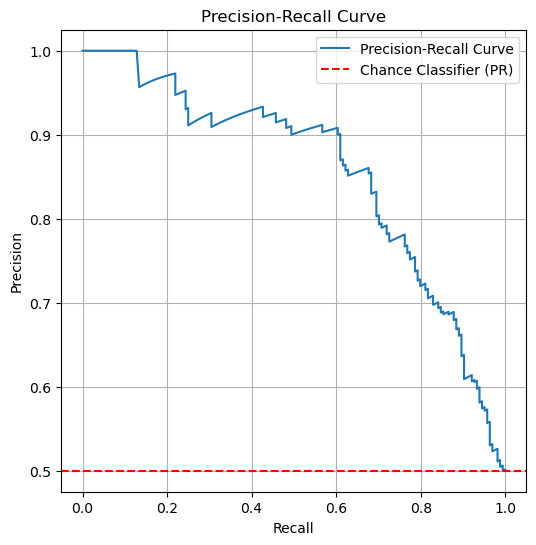

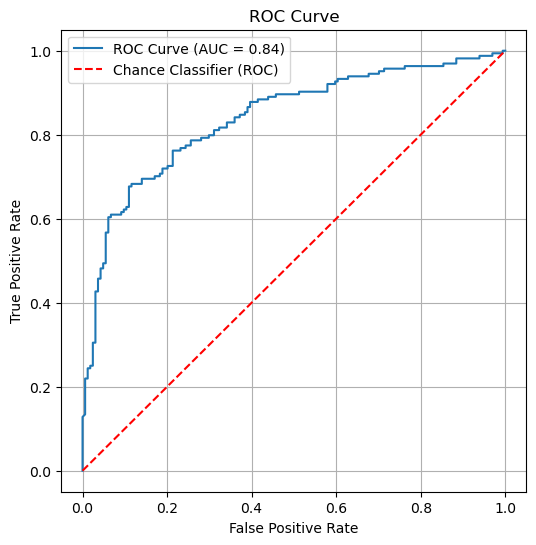

Training Accuracy (Final Epoch): 0.8435
Validation Accuracy (Final Epoch): 0.7023


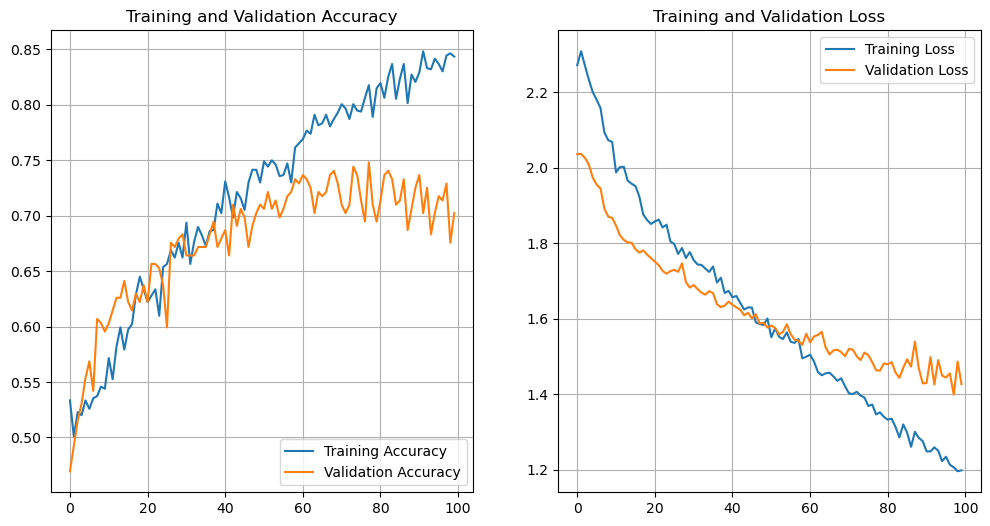

In [10]:
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, precision_recall_curve, roc_curve, auc
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras import regularizers
import tensorflow as tf
import random

# Fix random seed for reproducibility
def set_seed(seed=42):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

# Step 1: Load Latent Features (unchanged)
def load_latent_features(intra_dir):
    intra_features = []
    cross_features = None

    for idx, file in enumerate(sorted(os.listdir(intra_dir))):
        if file.endswith(".npy"):
            file_path = os.path.join(intra_dir, file)
            data = np.load(file_path)

            if idx < 9:
                intra_features.append(data)
            elif idx == 9:
                cross_features = data

    if cross_features is None:
        raise ValueError("Cross-channel latent features file (9th file) not found.")

    intra_features = np.stack(intra_features, axis=1)
    return intra_features, cross_features

# Step 2: Load Labels (unchanged)
def load_labels(labels_folder, channel_names):
    labels = np.zeros((819 * 2,))
    labels[:819] = 0
    labels[819:] = 1
    return labels

# Step 3: Channel Selection (unchanged)
def channel_selection(intra_features, alpha=1):
    num_samples, num_channels, latent_dim = intra_features.shape
    avg_activation = np.mean(intra_features, axis=0)
    response_energy = np.linalg.norm(intra_features - avg_activation[None, :, :], axis=2)
    avg_response_energy = np.mean(response_energy, axis=0)

    q = int(alpha * num_channels)
    top_channels = np.argsort(avg_response_energy)[-q:]
    selected_features = intra_features[:, top_channels, :]
    selected_features_flat = selected_features.reshape(num_samples, -1)

    return selected_features_flat, top_channels

# Step 4: Improved Model with Regularization, Complexity, and Learning Rate Adjustments
def build_improved_model(input_dim):
    model = models.Sequential()

    # Add initial dense layer with L2 regularization
    model.add(layers.InputLayer(input_shape=(input_dim,)))
    model.add(layers.Dense(512, activation='relu', 
                           kernel_regularizer=regularizers.l2(0.001)))  # L2 regularization
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.4))

    # Add another dense layer with BatchNormalization and Dropout
    model.add(layers.Dense(256, activation='relu', 
                           kernel_regularizer=regularizers.l2(0.001)))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.4))

    # Add more layers for increased complexity
    model.add(layers.Dense(128, activation='relu', 
                           kernel_regularizer=regularizers.l2(0.001)))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.4))

    # Add more layers for increased complexity
    model.add(layers.Dense(64, activation='relu', 
                           kernel_regularizer=regularizers.l2(0.001)))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.4))

    # Final output layer with softmax activation for binary classification
    model.add(layers.Dense(2, activation='softmax'))
    
    return model

# Learning Rate Scheduler: Gradual warm-up and exponential decay
def lr_schedule(epoch):
    initial_lr = 1e-4  # Starting with a smaller learning rate
    lr_decay = 0.96
    lr_drop = 10

    if epoch < 10:
        # Gradual warm-up phase (first 10 epochs)
        lr = initial_lr * (epoch + 1) / 10
    else:
        # Exponential decay after warm-up
        lr = initial_lr * (lr_decay ** (epoch // lr_drop))

    return lr

# Step 5: Train and Evaluate Classifier
def train_seizure_classifier(selected_features, cross_features, labels, output_dir, epochs=100, batch_size=16):
    set_seed(42)  # Set seed for reproducibility
    fusional_features = np.concatenate([selected_features, cross_features], axis=1)

    # Compute class weights
    class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(labels), y=labels)
    class_weights = dict(enumerate(class_weights))

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(fusional_features, labels, test_size=0.2, random_state=42, stratify=labels)

    # One-hot encode the labels
    y_train = to_categorical(y_train, num_classes=2)
    y_test = to_categorical(y_test, num_classes=2)

    # Build the improved model
    model = build_improved_model(fusional_features.shape[1])
    model.compile(optimizer=AdamW(), loss='binary_crossentropy', metrics=['accuracy'])

    # Apply learning rate scheduler
    lr_scheduler = LearningRateScheduler(lr_schedule, verbose=1)

    # Train the model
    history = model.fit(
        X_train, y_train,
        validation_split=0.2,
        epochs=epochs,
        batch_size=batch_size,
        class_weight=class_weights,
        verbose=2,
        callbacks=[lr_scheduler]
    )

    # Save the model
    os.makedirs(output_dir, exist_ok=True)
    model.save(os.path.join(output_dir, "seizure_classifier_improved.h5"))

    # Evaluate the model on the test set
    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")

    # Precision-Recall Curve
    y_pred_probs = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred_probs, axis=1)
    y_true_classes = np.argmax(y_test, axis=1)

    print("\nClassification Report:\n", classification_report(y_true_classes, y_pred_classes))

    precision, recall, _ = precision_recall_curve(y_true_classes, y_pred_probs[:, 1])
    plt.figure(figsize=(6, 6))
    plt.plot(recall, precision, label="Precision-Recall Curve")
    plt.axhline(y=0.5, color='red', linestyle='--', label="Chance Classifier (PR)")  # Chance classifier line
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
    plt.legend()
    plt.grid()
    plt.savefig("precision_recall_curve.jpg", format="jpg")  # Save as JPG
    plt.show()

# ROC Curve
    fpr, tpr, _ = roc_curve(y_true_classes, y_pred_probs[:, 1])
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(6, 6))
    plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], linestyle='--', color='red', label="Chance Classifier (ROC)")  # Chance classifier line
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.grid()
    plt.savefig("roc_curve.jpg", format="jpg")  # Save as JPG
    plt.show()

    # Training and Validation Accuracy and Loss
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(acc))

    print(f"Training Accuracy (Final Epoch): {acc[-1]:.4f}")
    print(f"Validation Accuracy (Final Epoch): {val_acc[-1]:.4f}")

    # Accuracy and Loss Plots
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label="Training Accuracy")
    plt.plot(epochs_range, val_acc, label="Validation Accuracy")
    plt.legend(loc="lower right")
    plt.title("Training and Validation Accuracy")
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label="Training Loss")
    plt.plot(epochs_range, val_loss, label="Validation Loss")
    plt.legend(loc="upper right")
    plt.title("Training and Validation Loss")
    plt.grid()

    plt.show()

# Step 6: Define Paths and Run Pipeline
if __name__ == "__main__":
    intra_dir = "denoising_AE_latent_output"
    labels_folder = "labels_folder"
    output_dir = "channel_aware_output"
    alpha = 1

    channel_names = ["#1", "#2", "#3", "#4", "#5", "#6", "#7", "#8", "#9"]

    intra_features, cross_features = load_latent_features(intra_dir)
    labels = load_labels(labels_folder, channel_names)

    selected_features, top_channels = channel_selection(intra_features, alpha=alpha)
    print(f"Top selected channels: {top_channels}")

    train_seizure_classifier(selected_features, cross_features, labels, output_dir)
